In [1]:
import os
import sys 
import glob
import dask
import pyproj
import pickle
import copy
import dask
import xsar
import xrft
import numpy as np
import scipy as sp
import pandas as pd
from pathlib import Path 
from matplotlib import pyplot as plt
import xarray as xr

import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from leakage.velocity_leakage import * #S1DopplerLeakage, add_dca_to_leakage_class, slant2ground, low_pass_filter_2D_dataset, low_pass_filter_2D
from leakage.misc import round_to_hour, angular_difference, calculate_distance, power_spectrum_custom

func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)
rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)), rounding)


In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenario = 'Azores_20201127' # 'Aghulas_20200427'# 'Azores_20201127'
version = 'v3'
csv_file = f'../../data/leakage/temp/{scenario}_variables_perf_{version}.csv'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

In [3]:
test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='../../data/leakage/era5_winds/',
    resolution_product=50_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=75,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'phased_array', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=35,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = 1,
    product_averaging_window='hann',
    # _gamma_hardcode = 
    # _interpolator = 'linear',
    # era5_smoothing_window=30,
    # denoise = True,
    # _pulsepair_noise = True
    # _speckle_noise= False
    )


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:596: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [4]:
N_T_pp = 7  #-5
T_pps = np.logspace(-6, -3, N_T_pp)
SNRs = 2**np.arange(0, 14, 2)
N_SNR = len(SNRs)
dB = lambda x: 10*np.log10(x)
T_corr_Doppler = 1E-4
T_corr_surface = 30E-3
  
file_path = Path(csv_file) 
if not file_path.exists(): 
    df = pd.DataFrame(columns=["index", "T_pp", "SNR", "rmse total", "rmse leakage", "rmse total post correction", "rmse leakage post correction", "rmse contribution from pp"])
    df.to_csv(csv_file, index = False)
else: 
    print(f"The file '{file_path}' already exists.") 
    df = pd.read_csv(csv_file)

df

The file '../../data/leakage/temp/Azores_20201127_variables_perf_v3.csv' already exists.


,index,T_pp,SNR,rmse total,rmse leakage,rmse total post correction,rmse leakage post correction,rmse contribution from pp
0,1.0,0.000001,1.0,218.759,1.203,218.740,0.419,218.743
1,2.0,0.000001,4.0,151.330,1.203,151.306,0.419,151.307
2,3.0,0.000001,16.0,91.284,1.203,91.249,0.419,91.245
3,4.0,0.000001,64.0,51.138,1.203,51.109,0.419,51.100
4,5.0,0.000001,256.0,27.775,1.203,27.746,0.419,27.731
5,6.0,0.000001,1024.0,15.043,1.203,14.971,0.419,14.954
6,7.0,0.000001,4096.0,8.418,1.203,8.284,0.419,8.266
7,8.0,0.000003,1.0,69.201,1.203,69.176,0.419,69.178
8,9.0,0.000003,4.0,47.894,1.203,47.861,0.419,47.860
9,10.0,0.000003,16.0,28.943,1.203,28.893,0.419,28.888


## Processing

In [5]:
input_T_pp = np.broadcast_to(T_pps, (N_SNR, N_T_pp)).T.ravel()
input_SNR = np.broadcast_to(SNRs, (N_T_pp, N_SNR)).ravel()

counter = df.index.stop
idx_start = df.index.stop

# for T_pp, SNR in zip(input_T_pp[idx_start:], input_SNR[idx_start:]):
for T_pp, SNR in zip(input_T_pp, input_SNR):
    counter += 1

    test.T_pp = T_pp
    test.SNR = SNR
    test.apply()

    net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
    net_velocity_error =  test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
    plot_cut = net_velocity_error / net_velocity_error

    fs_x = 1/test.grid_spacing
    fs_y = 1/test.stride

    pulse_pair_noise = test.data.V_sigma - test.data.V_leakage_pulse_rg

    V_pp_low_pass = low_pass_filter_2D(pulse_pair_noise, 
                        cutoff_frequency= 1/test.resolution_product,
                        fs_x=fs_x,
                        fs_y=fs_y,
                        fill_nans = True)

    variables = [
        test.data.V_sigma_subscene * plot_cut,
        test.data.V_leakage_pulse_rg_subscene * plot_cut,
        (test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted ) * plot_cut,
        net_leakage * plot_cut, 
        V_pp_low_pass * plot_cut
    ]

    rmses = [func_rmse(i) for i in variables]
    
    df = pd.read_csv(csv_file)
    df.loc[counter] = [counter, T_pp, SNR, *rmses]
    df.to_csv(csv_file, index = False)

## Analyses

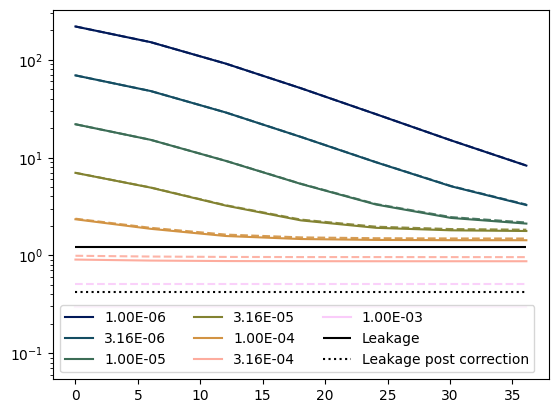

In [7]:
from matplotlib.colors import ListedColormap

grouped = df.groupby('T_pp')
ys = grouped['rmse contribution from pp'].apply(list).reset_index().values#.values#.sample()
ys2 = grouped['rmse total post correction'].apply(list).reset_index().values

labels = list(grouped.indices.keys())

colormap = cmc.batlow
discrete_cmap = colormap(np.linspace(0, 1, len(labels)))
cmap = ListedColormap(discrete_cmap)

for y, y2, c in zip(ys, ys2, cmap.colors):
    plt.semilogy(dB(SNRs), y[1], label = f"{y[0]:1.2E}", linestyle = '-', c = c)
    # plt.semilogy(dB(SNRs), y[1] / np.sqrt( 1.15E-4/y[0] ), label = f"{y[0]:1.2E}", linestyle = '-', c = c)
    plt.semilogy(dB(SNRs), y2[1], linestyle = '--', c = c, alpha = 0.9)

plt.hlines(df['rmse leakage'].values[0], xmin=min(dB(SNRs)), xmax=max(dB(SNRs)), label= 'Leakage', color = 'k')
plt.hlines(df['rmse leakage post correction'].values[0], xmin=min(dB(SNRs)), xmax=max(dB(SNRs)), label= 'Leakage post correction', color = 'k', linestyle = ':')
plt.legend(ncol = 3)

Text(0.5, 0, '$\\gamma \\ [-]$')

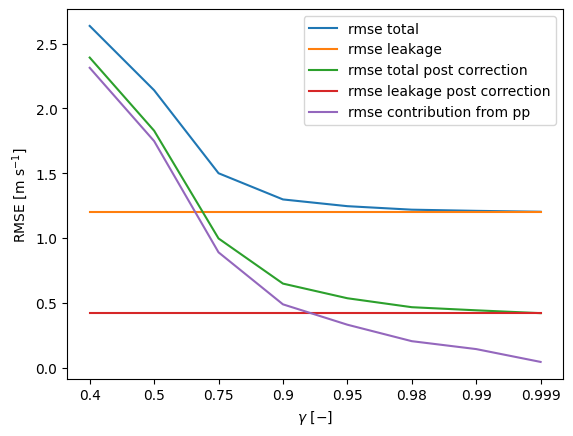

In [ ]:
# df.plot()
# plt.xlabel(gammas)
ax = df.plot()
ax.set_xticks(np.arange(0, 8))
ax.set_xticklabels(gammas)
ax.set_ylabel(r'${\rm RMSE}\ [\rm m\ s^{-1}]$')
ax.set_xlabel(r'$\gamma \ [-]$')

In [ ]:
rmses_all

[[2.636, 1.203, 2.392, 0.419, 2.313],
 [2.14, 1.203, 1.828, 0.419, 1.748],
 [1.5, 1.203, 0.997, 0.419, 0.89],
 [1.298, 1.203, 0.649, 0.419, 0.489],
 [1.246, 1.203, 0.536, 0.419, 0.332],
 [1.219, 1.203, 0.467, 0.419, 0.205],
 [1.21, 1.203, 0.443, 0.419, 0.144],
 [1.203, 1.203, 0.421, 0.419, 0.045]]